# Recognizing and Classifying Flowers using Deep Learning with PyTorch

- toc: true
- badges: true

## Introduction

In this project, we are going to work on the [flowers-recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) dataset on Kaggle. There are a total of 4242 images of flowers in this dataset. It is based on the data from flickr, google images, yandex images. The pictures are divided into five classes in the dataset: chamomile, tulip, rose, sunflower, and dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions. 

Our task is to train a ML model on the dataset and predict the correct classes of the flowers. We will use the PyTorch framework to train a deep learning neural net model to do so. And to accelerate learning, we will take help of the GPU. 

This will involve:
- loading the dataset with some transformations
- splitting it into training and validation sets
- transferring the dataset to the GPU
- building training utility functions
- building model
- training
- making predictions

## Setup

First, import the required libraries and get the data directory

In [1]:

# import libraries
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torch.nn as nn
from torch.nn import functional as F
from psutil import cpu_count
import matplotlib.pyplot as plt
import os

In [2]:

# look at directories
for dir_path, _, filenames in os.walk("/kaggle/input/flowers-recognition"):
    print(dir_path)

/kaggle/input/flowers-recognition
/kaggle/input/flowers-recognition/flowers
/kaggle/input/flowers-recognition/flowers/dandelion
/kaggle/input/flowers-recognition/flowers/daisy
/kaggle/input/flowers-recognition/flowers/sunflower
/kaggle/input/flowers-recognition/flowers/tulip
/kaggle/input/flowers-recognition/flowers/rose


As we can see, the images are classified in folders with the target classes given in their folder names.
We can look at the number of images per target class now and see that if the classes are heavily imbalanced.

In [3]:

# set data directory
data_dir = "/kaggle/input/flowers-recognition/flowers"

# list number of images per class
for clas in os.listdir(data_dir):
    print(clas, ":", len(os.listdir(data_dir + "/" + clas)))

dandelion : 1052
daisy : 764
sunflower : 733
tulip : 984
rose : 784


The classes don't look to be highly imbalanced. We can move on to load the data using `torchvision.datasets.ImageFolder` This will automatically assign labels from the folder names.

In [4]:

# load data
dataset = ImageFolder(data_dir)

# inspect classes
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

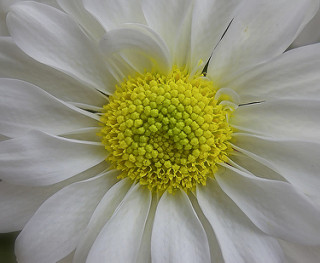

In [5]:

# inspect image
dataset[0][0]

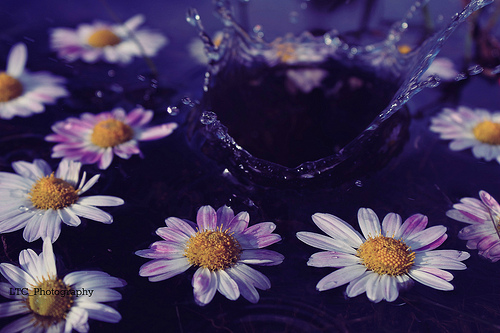

In [6]:

# inspect another image
dataset[3][0]

### Data Preprocessing

The images are of different sizes. Thus, for the model to train, we'll need to resize images to a common size. To do this, we'll transform images while loading using `torchvision.transforms`. 

In [7]:

# image transformer
transfms = tt.Compose([tt.Resize(128), tt.RandomCrop(128), tt.ToTensor()])

In [19]:

# load the data again, this time with the transformer
dataset = ImageFolder(data_dir, transfms)

dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /kaggle/input/flowers-recognition/flowers
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(128, 128), padding=None)
               ToTensor()
           )

In [20]:

# inspect image dimensions
img, label = dataset[0]
img.shape

torch.Size([3, 128, 128])

Each element from the training data set is a tuple, containing a image tensor and a label. Since the data consists of 128 x 128 px color images with 3 channels (RGB). So, each image tensor has the shape (3, 128, 128). We can look at some of the images now. To do this, we'll also need to permute the images to shift the channel info to last dimension because matplotlib  expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension).

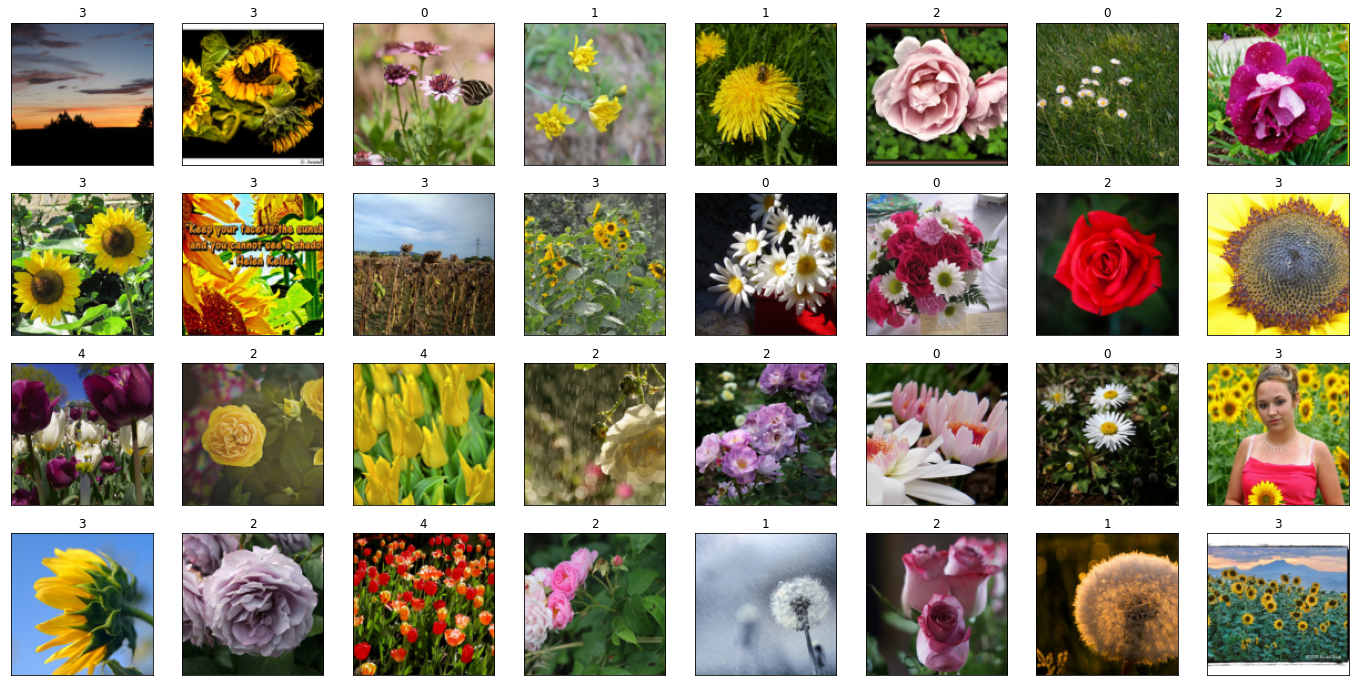

In [21]:

# inspect some images
fig, ax = plt.subplots(4, 8, figsize = (24, 12), subplot_kw = {"xticks": [], "yticks": []})

for axes, i in zip(ax.flat, np.random.randint(0, len(dataset), 32)):
    image, label = dataset[i]
    image = torch.permute(image, (1,2,0))

    axes.imshow(image)
    axes.set_title(label)

The images look to be alright. Now, we'll split the data into training and validation sets.

In [22]:

# get the split sizes

valid_frac = 0.15
valid_size = int(valid_frac * len(dataset))
train_size = len(dataset) - valid_size

train_size, valid_size

(3670, 647)

In [23]:

# split the data

train_ds, valid_ds = random_split(dataset, lengths = (train_size, valid_size))

len(train_ds), len(valid_ds)

(3670, 647)

Now, we’ll create Data Loaders, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [24]:

# create DataLoader(s)
core_count = cpu_count(logical = False)
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = core_count, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers = core_count, pin_memory = True)

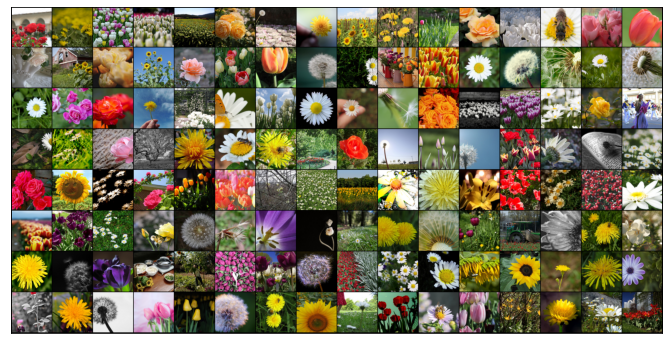

In [25]:

# look at some the images from training dataloader
for images, label in train_dl:
    fig, ax = plt.subplots(figsize = (12, 6), subplot_kw = {"xticks": [], "yticks": []})
    
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

    break

## GPU Utility Functions

We'll use GPU to accelerate training the deep learning model, as they are better suited for parallel computation which is required in training such models. To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [34]:

# GPU Utils
def get_device():
    """pick a GPU if availabe, else pick CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    """move tensors to the given device"""
    if isinstance(data, (list, tuple)):
        return (to_device(x, device) for x in data)
    return data.to(device, non_blocking = True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for data in self.dl:
            yield to_device(data, self.device)
    
    def __len__(self):
        return len(self.dl)

Now, we can wrap up our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [28]:

# define dataloaders with devices
device = get_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model & Training Utility Functions

Now, we'll need to create some utility functions for defining the model and training the model. 

We'll define an ImageClassificationBase class whose functions are:
- To figure out how “wrong” the model is going after training or validation step, other than just an accuracy metric that is likely not going to be differentiable (this would mean that the gradient can’t be determined, which is necessary for the model to improve during training)? We'll use the `cross_entropy` function for this.
- Because an accuracy metric can’t be used while training the model, doesn’t mean it shouldn’t be implemented! Accuracy in this case would be measured by a threshold, and counted if the difference between the model’s prediction and the actual label is lower than that threshold.
- to track the validation losses/accuracies and train losses after each epoch, and every time we do so we have to make sure the gradient is not being tracked.
- to print validation losses/accuracies, and train losses. 

We also define an accuracy function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in fit_one_cycle.

In [29]:

# Model Utils
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean().item()
        batch_accs = [x["val_accuracy"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean().item()
        return {"val_loss": epoch_loss, "val_acc": epoch_acc}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


Now, we'll define the training utilities. 

We'll create an evaluate function which will use the model utility functions to output the validation losses and accuracies. This function will be used to evaluate the performance of the model training.

We'll also create a fit function which will actually carry out the training. This function will:
- train the model in batches using the train_dl that we defined earlier. The training will be done for the passed no. of epochs. 
- take in a learning rate and an optimizer funtion to carry out the gradient descent with the passed learning rate. 
- evaluate performance of model training for each epoch and print the results using the defined utilty functions. 
- save and return history of training of all the epochs. 

In [30]:

# Training Utils
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    result = model.validation_epoch_end(outputs)
    return result

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

## Model

Now, we can actually define the training model. We'll define a conv_block first, which will be made up of multiple neural net layers. This block will be used multiple times in the model. 

For the model, we'll use a ResNet Architecture similar to this. 

![](https://miro.medium.com/max/1400/0*sdcK1I1NCqbDwiZY.png)


In [31]:
def conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool = True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                 conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool = True)
        self.conv4 = conv_block(256, 512, pool = True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                 conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                       nn.Flatten(),
                                       nn.Dropout(0.2),
                                       nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out

We'll now define the model and transfer it to the available device.

In [32]:

# define model
model = to_device(ResNet9(3, len(dataset.classes)), device)

# inspect model's structure
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training

Let's first check the validation loss and accuracy pre-training.

In [33]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.690361499786377, 'val_acc': 0.2654390037059784}]

Because the model is untrained now, it gives out a validation accuracy of about 0.265 and validation loss of about 3.69. Now we, can fit the model with learning rate 0.001 and see how the accuracy improves and the loss drops. 

In [34]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5506, val_loss: 1.0906, val_acc: 0.5653
Epoch [1], train_loss: 1.0604, val_loss: 1.1143, val_acc: 0.6057
Epoch [2], train_loss: 0.9445, val_loss: 0.8187, val_acc: 0.6975
Epoch [3], train_loss: 0.8619, val_loss: 0.8108, val_acc: 0.7292
Epoch [4], train_loss: 0.7657, val_loss: 0.7326, val_acc: 0.7444


In [35]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.0369, val_loss: 0.8243, val_acc: 0.7001
Epoch [1], train_loss: 0.7910, val_loss: 0.7751, val_acc: 0.7132
Epoch [2], train_loss: 0.6564, val_loss: 0.6475, val_acc: 0.7626
Epoch [3], train_loss: 0.6147, val_loss: 0.5940, val_acc: 0.7956
Epoch [4], train_loss: 0.5650, val_loss: 0.5741, val_acc: 0.7930


In [36]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6777, val_loss: 0.5832, val_acc: 0.7861
Epoch [1], train_loss: 0.5352, val_loss: 0.6066, val_acc: 0.7874
Epoch [2], train_loss: 0.4847, val_loss: 0.5255, val_acc: 0.8216
Epoch [3], train_loss: 0.4510, val_loss: 0.4884, val_acc: 0.8438
Epoch [4], train_loss: 0.4142, val_loss: 0.5026, val_acc: 0.8164


In [37]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4886, val_loss: 0.5936, val_acc: 0.8173
Epoch [1], train_loss: 0.4022, val_loss: 0.5305, val_acc: 0.8255
Epoch [2], train_loss: 0.3879, val_loss: 0.5654, val_acc: 0.8030
Epoch [3], train_loss: 0.3676, val_loss: 0.5324, val_acc: 0.8160
Epoch [4], train_loss: 0.2977, val_loss: 0.4672, val_acc: 0.8620


In [56]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.2223, val_loss: 0.4172, val_acc: 0.8698
Epoch [1], train_loss: 0.1879, val_loss: 0.4361, val_acc: 0.8685
Epoch [2], train_loss: 0.1731, val_loss: 0.4327, val_acc: 0.8724
Epoch [3], train_loss: 0.1803, val_loss: 0.4359, val_acc: 0.8750
Epoch [4], train_loss: 0.1610, val_loss: 0.4129, val_acc: 0.8750


Now, that the validation accuracy has stopped improving even when training loss keeps on dropping, we will stop the training otherwise the model will overfit the training data.

We can now plot and visualize how the training went through.

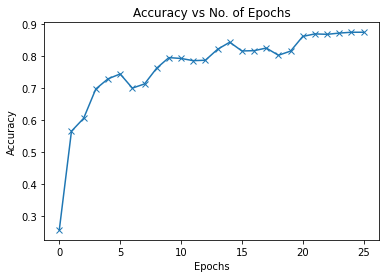

In [57]:

# vizualize validation accuracy in training
def plot_accuracies(history):
    accs = [x['val_acc'] for x in history]
    plt.plot(accs, "-x")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs No. of Epochs")
    
plot_accuracies(history)

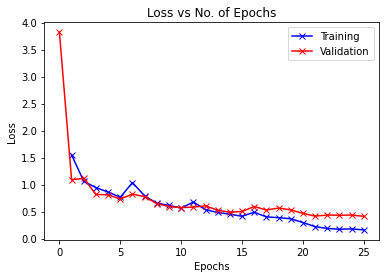

In [58]:

# visualize losses
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x.get("val_loss") for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs No. of Epochs")
    
plot_losses(history)

In the loss plot we can see that the validation loss flattened out in the end and was starting to diverge from the training loss, thus it was a right decision to stop training at that point. Both graphs also show how quickly the model improved in its performance.

## Predictions

We'll now look at some of the predictions that the model makes and then save the model for future use.

In [138]:

# function to get predictions from model
def get_pred(model, image):
    image = to_device(image.unsqueeze(0), device)
    pred = model(image)
    
    indx = torch.max(pred, 1)[1]
    return dataset.classes[indx.item()]
    

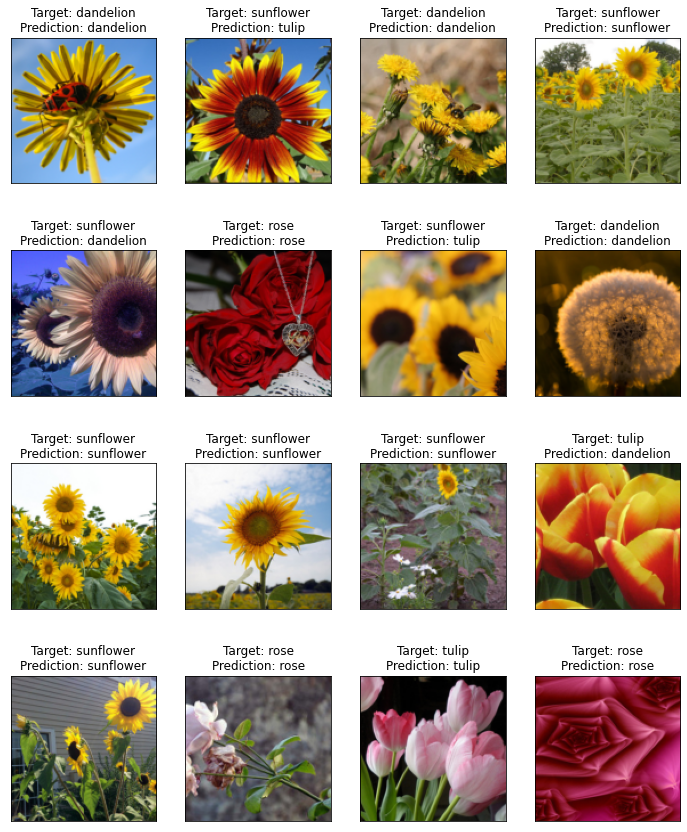

In [145]:

# visualize predictions
fig, axs = plt.subplots(4, 4, figsize = (12, 15), subplot_kw = {"xticks": [], "yticks": []})
    
for i, ax in zip(np.random.randint(1, len(valid_ds), 16), axs.flat):
    image = valid_ds[i][0]
    label = dataset.classes[valid_ds[i][1]]
    
    pred_label = get_pred(model, image)
    
    ax.imshow(torch.permute(image, (1, 2, 0)))
    ax.set_title(f"Target: {label}\nPrediction: {pred_label}")

This sample of predictions turned out well. Now, we can save the model for later use.

In [146]:
# save model
torch.save(model, "flower_class_ResNet9.pth")

## Summary and Conclusion

In this project, we worked on image classification. We had to classify flowers into 5 target classes from the dataset [flowers-recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition). This involved loading the dataset onto GPU and defining multiple GPU, model, and training utiltiy functions. We were able to build a ResNet9 model using convolutional neural network that can recognize images with an accuracy of 87% using Pytorch. We inspected some of the predictions that the model made and they turned out to be good and then we saved the model for future use. 

Thanks for reading.